In [11]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn
#print(torch_geometric.__version__)
from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import itertools

import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling
import numpy as np

# EdgeAdding
# EdgeRemoving
# NodeDropping
# Random Walk Sampling

# FeatureDropout
# FeatureMasking

# EdgeAttrMasking
# EdgeAttrDropout

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

1.13.1+cu117
cuda


In [2]:

parameters = {}
parameters['batch_size'] = 2048 # This could be much higher - not sure what was causing memory errors earlier
parameters['n_epochs'] = 30
parameters['learning_rate'] = 0.002

In [3]:
whole_dataset = QM9(root = 'data/')


n = whole_dataset.len()
tr_n = 0.5  # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
print(len(tr_inds), len(val_inds))
print(type(tr_inds), type(tr_inds[0]))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)

# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)
                                                #sampler = train_sampler)
big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = 4096*2,
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=4096*2, # I am using this to get a random subset of the val set
                                            shuffle=True, num_workers=2,)
                                              #sampler = val_sampler)
    
val_aug = A.RandomChoice([], num_choices = 0)


65415 65416
<class 'list'> <class 'int'>


In [4]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

print(qm9_index.items())

dict_items([(0, 'Dipole moment'), (1, 'Isotropic polarizability'), (2, 'Highest occupied molecular orbital energy'), (3, 'Lowest unoccupied molecular orbital energy'), (4, 'Gap between previous 2'), (5, 'Electronic spatial extent'), (6, 'Zero point vibrational energy'), (7, 'Internal energy at 0K'), (8, 'Internal energy at 298.15K'), (9, 'Enthalpy at 298.15K'), (10, 'Free energy at 298.15K'), (11, 'Heat capavity at 298.15K'), (12, 'Atomization energy at 0K'), (13, 'Atomization energy at 298.15K'), (14, 'Atomization enthalpy at 298.15K'), (15, 'Atomization free energy at 298.15K'), (16, 'Rotational constant A'), (17, 'Rotational constant B'), (18, 'Rotational constant C')])


In [5]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb

## Here is my proposal for a neural network baseline, which is trained in a supervised manner
# But maintains the same architecture as the VicReg model.
# It could be trained to predict 19 outputs, or 1, or some amount.
# Then you could transfer it to other outputs with transfer learning technique (new head)
class Supervised_GCN_Equivalent(torch.nn.Module):
    def __init__(self, c_dim):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        self.c_dim = c_dim
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Projection to embedding
        self.fc2 = nn.Linear(self.rep_dim, self.c_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        yhat = self.fc2(x_rep)
        
        return yhat

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = parameters['n_epochs']
    aug = parameters['augmentation']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)

            # Barlow - get 2 random views of batch
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)

            loss = VicRegLoss(e1, e2)
            loss.backward()
            optimizer.step()

            #epoch_losses.append(loss.data.item())

        #print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        #tr_losses.append(sum(epoch_losses) / len(epoch_losses))
        
        # VicReg Validation Loss
        if True:
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))
    
    return model, tr_losses, val_losses

def test(model, big_train_loader, val_loader, parameters):
    # Downstream supervised loss      
    scores = []
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))

            for i, val_batch in enumerate(val_loader):
                print('doing a batch')
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    scores.append(mse_met)
                    
                if i==0:
                    break # Only want first batch, please
                    
    return scores

import os
def trymkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

In [6]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb

## Here is my proposal for a neural network baseline, which is trained in a supervised manner
# But maintains the same architecture as the VicReg model.
# It could be trained to predict 19 outputs, or 1, or some amount.
# Then you could transfer it to other outputs with transfer learning technique (new head)
class Supervised_GCN_Equivalent(torch.nn.Module):
    def __init__(self, c_dim):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        self.c_dim = c_dim
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Projection to embedding
        self.fc2 = nn.Linear(self.rep_dim, self.c_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        yhat = self.fc2(x_rep)
        
        return yhat

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = parameters['n_epochs']
    aug = parameters['augmentation']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)

            # Barlow - get 2 random views of batch
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)

            loss = VicRegLoss(e1, e2)
            loss.backward()
            optimizer.step()

            #epoch_losses.append(loss.data.item())

        #print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        #tr_losses.append(sum(epoch_losses) / len(epoch_losses))
        
        # VicReg Validation Loss
        if True:
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))
    
    return model, tr_losses, val_losses

def test(model, big_train_loader, val_loader, parameters):
    # Downstream supervised loss      
    scores = []
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))

            for i, val_batch in enumerate(val_loader):
                print('doing a batch')
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    scores.append(mse_met)
                    
                if i==0:
                    break # Only want first batch, please
                    
    return scores

import os
def trymkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

In [15]:
metrics = [mean_squared_error, mean_absolute_error, r2_score]
import copy

QM9 6 0 3 2400 12,918,312


def test_supervised(model, dataloader, parameters):
    # Test the supervised model on a set
    task_index = parameters['task']
    
    scoremat = [ [] for _ in range(len(metrics)) ]
    print(scoremat)
    
    for batchi, batch in enumerate(val_loader):
        
        batch_inds = batch.batch.to(device)
        batch.x = batch.x.float()#.to(device)

        # Augment batch?
        #batch = aug(batch.x, batch.edge_index, batch.edge_attr)
        
        with torch.no_grad():
            yhat = model([batch.x, batch.edge_index, batch.edge_attr], batch_inds).cpu().squeeze()
        
        print('going into metrics', yhat.shape, batch.y[:,task_index].shape)
        # Metrics
        for meti, metric in enumerate(metrics):
            met = metric(yhat, batch.y[:,task_index])
            scoremat[meti].append(met)
        
    print('Returning validation scores mat', torch.FloatTensor(scoremat).shape)
    return torch.FloatTensor(scoremat)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def transfer_supervised(model, val_loader, parameters):
    # Transfer a model trained under the supervised paradigm

    
    model_copy = copy.deepcopy(model)
    
    model_copy.fc2 = Identity()
    
    # Need to get training set embeddings:
    train_batch = next(iter(train_loader))
    with torch.no_grad():
        tr_emb = model_copy([train_batch.x.float().to(device), train_batch.edge_index, train_batch.edge_attr], train_batch.batch.to(device)).cpu()
        print('train embeddings', tr_emb.shape)
    
    val_batch = next(iter(val_loader))

    batch_inds = val_batch.batch.to(device)
    val_batch.x = val_batch.x.float()#.to(device)

    # Augment batch?
    #batch = aug(batch.x, batch.edge_index, batch.edge_attr)

    with torch.no_grad():
        val_emb = model_copy([val_batch.x, val_batch.edge_index, val_batch.edge_attr], batch_inds).cpu()
        print('batch embeding:', val_emb.shape)

    scoremat = torch.zeros((len(qm9_index.keys()), len(metrics)))
    for task in qm9_index.keys():
        print('task', task, qm9_index[task])
        linear_classifier = LinearRegression().fit(tr_emb, train_batch.y[:,task])
        yhat = linear_classifier.predict(val_emb)
        for meti, metric in enumerate(metrics):
            met = metric(yhat, val_batch.y[:,task])
            scoremat[task, meti] = met.astype(np.float64)
            
    print('Returning transfer scores', scoremat.shape)
    return scoremat

    
def train_supervised(parameters):
    
    # Get target types from parameters - one task or 19?
    task_index = parameters['task'] # An index for which task the model is trained on - or 'all'
    
    if task_index == 'all':
        #task_index = [0:]
        pass
    else:
        #task_index = [task:task+1]
        pass
    
    device = 'cuda'
    model = Supervised_GCN_Equivalent(c_dim = 1).to(device)
    
    mse_loss = torch.nn.MSELoss()
    n_epochs = parameters['n_epochs']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)
            
            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)
            #print(batch.x.shape, batch.y.shape)

            # Augment batch?
            #batch = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            yhat = model([batch.x, batch.edge_index, batch.edge_attr], batch_inds).squeeze()
            
            #print(yhat, type(yhat), yhat[0].shape)
            #print('in supervised training', yhat.shape, batch.y[:,task_index].shape)
            loss = mse_loss(yhat, batch.y[:,task_index].to(device))
            loss.backward()
            optimizer.step()
            
            
            epoch_losses.append(loss.data.item())
                        
        # test the model
        scores = supervised_loss  = test_supervised(model, val_loader, parameters)
        transfer_loss = transfer_supervised(model, val_loader, parameters)
        
        print('Epoch loss:', round(sum(epoch_losses) / len(epoch_losses), 2))
        print('Validation scores:', scores)
        print('Transfer scores:', transfer_loss)

if True:
    parameters['task'] = 0
    print('Training a supervised model to predict', qm9_index[parameters['task']])
    train_supervised(parameters)

Training a supervised model to predict Dipole moment
[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task

batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 298.15K
task 12 Atomization energy at 0K
task 13 Atomization energy at 298.15K
task 14 Atomization enthalpy at 298.15K
task 15 Atomization free energy at 298.15K
task 16 Rotational constant A
task 17 Rotational constant B
task 18 Rotational constant C
Returning transfer scores torch.Size([19, 3])
Epoch loss: 1.79
Validation scores: tensor([[ 1.7912,  1.7330,  1.7935,  1.7334,  1.8108,  1.7755,  1.7391,  1.6986],
        [ 1.0061,  0.9855,  1.0013,  0.9995,  1.0153,  0.9997,  0.9857,  0.9877],
        [-1.7622, -1.7429, -1.7642, -1.6095, -1.8163, -1.7105, -

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

[[], [], []]
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8192]) torch.Size([8192])
going into metrics torch.Size([8072]) torch.Size([8072])
Returning validation scores mat torch.Size([3, 8])
train embeddings torch.Size([2048, 128])
batch embeding: torch.Size([8192, 128])
task 0 Dipole moment
task 1 Isotropic polarizability
task 2 Highest occupied molecular orbital energy
task 3 Lowest unoccupied molecular orbital energy
task 4 Gap between previous 2
task 5 Electronic spatial extent
task 6 Zero point vibrational energy
task 7 Internal energy at 0K
task 8 Internal energy at 298.15K
task 9 Enthalpy at 298.15K
task 10 Free energy at 298.15K
task 11 Heat capavity at 2

In [ ]:
# # This study is on the effect of the NUMBER of augmentations

# # For N trials:

# # Sample N random augmentations from auglist (without replacement!)

# # Train, validate with that model

# # Assemble results given n augmentations

# # For 1,...,k augmentations:
# augs = [A.RWSampling(num_seeds=1000, walk_length=10),
#         A.EdgeAttrmasking(),
#         A.MarkovDiffusion(),
#         A.NodeDropping(pn=0.1),
#         #A.EdgeAdding(pe=0.1),
#         A.FeatureMasking(pf=0.1),
#         A.EdgeRemoving(pe=0.1)]

# parameters['n_epochs'] = 1
# auglist = []
# for i, aug in enumerate(augs):
#     # Design an augmentation
#     auglist.append(aug)
#     print(auglist)
#     augmentation = A.RandomChoice(auglist, num_choices=1)
    
#     # Train with that augmentation
#     parameters['augmentation'] = augmentation
#     model, tr_losses, val_losses = train(parameters)
    
#     # Test with that augmentation
#     scores = test(model, big_train_loader, val_loader, parameters)
    
#     # Visualize validation loss
#     plt.plot(val_losses, label = f'Augmentation Set Length {i}')
    
#     # Print some scores
#     print('Validation set Dipole Moment MSE: ', scores[0])
    
#     torch.save(aug, f'aug_sweep1234/aug_{i}.pt')
#     torch.save(scores, f'aug_sweep1234/scores_{i}.pt')
#     print(scores)

In [16]:
# This study:
# For n trials, randomly sample a length of aug_n augmentations from the list
# Train a vicreg on that augmentation composition
# test the vicreg
# assemble the results based on the LENGRH of augmentations

import random

n_trials = 10
max_augs = 6

augs = [A.RWSampling(num_seeds=1000, walk_length=10),
        #A.EdgeAttrMasking(pf=0.1),
        #A.MarkovDiffusion(),
        A.NodeDropping(pn=0.1),
        A.NodeShuffling(),
        #A.EdgeAdding(pe=0.1),
        A.FeatureMasking(pf=0.1),
        A.FeatureDropout(pf=0.1),
        A.EdgeRemoving(pe=0.1)]

parameters['n_epochs'] = 20

#colors = ['red', 'blue', 'green', 'black', 'yellow']

for aug_n in range(1, max_augs+1):
    
    for trial in range(n_trials):
        print(f'Augmentation length {aug_n} - trial {trial}')
        
        if os.path.isfile(f'aug_sweepBigger/scores_{aug_n}_{trial}.pt'):
            print('Experiment exists, continue')
            val_losses = torch.load(f'aug_sweepBigger/val_{aug_n}_{trial}.pt')
            #plt.plot(val_losses, label = f'Augmentation Set Length {aug_n}', color = colors[aug_n-1])
        else:

            augmentation_list = random.sample(augs, aug_n)
            print(augmentation_list)
            augmentation = A.RandomChoice(augmentation_list, num_choices=1)

            # Train with that augmentation
            parameters['augmentation'] = augmentation
            model, tr_losses, val_losses = train(parameters)

            # Test with that augmentation
            scores = test(model, big_train_loader, val_loader, parameters)

            # Visualize validation loss
            #plt.plot(val_losses, label = f'Augmentation Set Length {aug_n}', color = colors[aug_n-1])

            # Print some scores
            print('Validation set Dipole Moment MSE: ', scores[0])

            torch.save(tr_losses, f'aug_sweepBigger/tr_{aug_n}_{trial}.pt') # save the training scores
            torch.save(val_losses, f'aug_sweepBigger/val_{aug_n}_{trial}.pt') # save the validation scores
            torch.save(augmentation_list, f'aug_sweepBigger/aug_{aug_n}_{trial}.pt') # save the augmentation
            torch.save(scores, f'aug_sweepBigger/scores_{aug_n}_{trial}.pt') # save the scores
        
#plt.legend(loc = 'best')
#plt.xlabel('Training iterations')
#plt.ylabel('VicReg Validation Losses')
#plt.show()

Augmentation length 1 - trial 0
Experiment exists, continue
Augmentation length 1 - trial 1
Experiment exists, continue
Augmentation length 1 - trial 2
Experiment exists, continue
Augmentation length 1 - trial 3
Experiment exists, continue
Augmentation length 1 - trial 4
Experiment exists, continue
Augmentation length 1 - trial 5
Experiment exists, continue
Augmentation length 1 - trial 6
Experiment exists, continue
Augmentation length 1 - trial 7
Experiment exists, continue
Augmentation length 1 - trial 8
Experiment exists, continue
Augmentation length 1 - trial 9
Experiment exists, continue
Augmentation length 2 - trial 0
Experiment exists, continue
Augmentation length 2 - trial 1
Experiment exists, continue
Augmentation length 2 - trial 2
Experiment exists, continue
Augmentation length 2 - trial 3
Experiment exists, continue
Augmentation length 2 - trial 4
Experiment exists, continue
Augmentation length 2 - trial 5
Experiment exists, continue
Augmentation length 2 - trial 6
Experime

Saving to imgs/aug_sweepBiggerImgs/Dipole moment_n_augs_multitrial.png


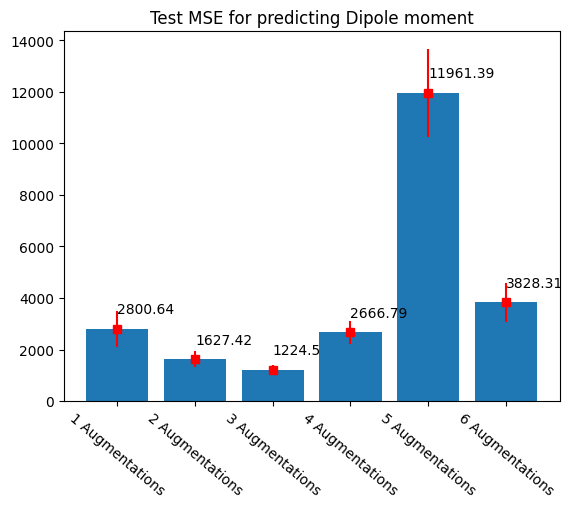

Saving to imgs/aug_sweepBiggerImgs/Isotropic polarizability_n_augs_multitrial.png


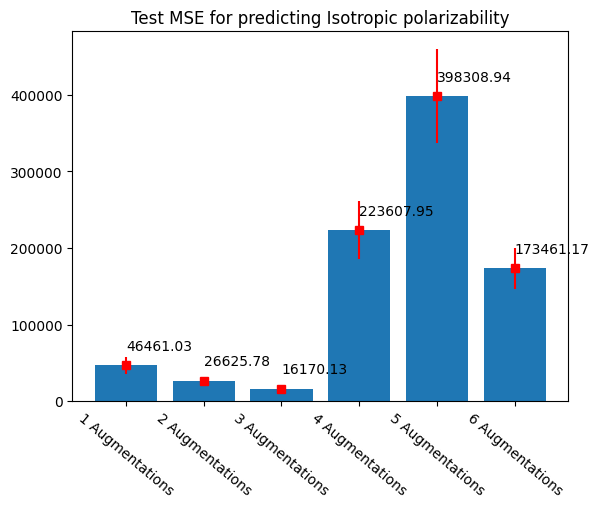

Saving to imgs/aug_sweepBiggerImgs/Highest occupied molecular orbital energy_n_augs_multitrial.png


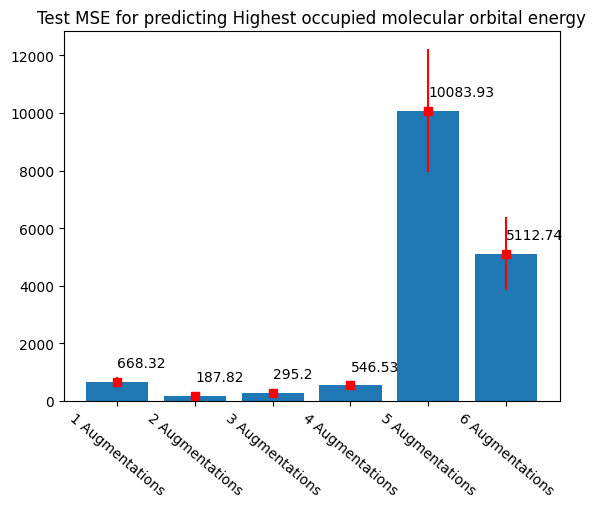

Saving to imgs/aug_sweepBiggerImgs/Lowest unoccupied molecular orbital energy_n_augs_multitrial.png


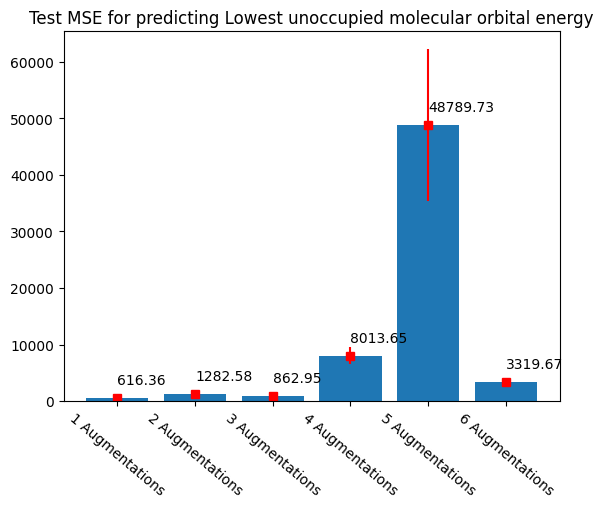

Saving to imgs/aug_sweepBiggerImgs/Gap between previous 2_n_augs_multitrial.png


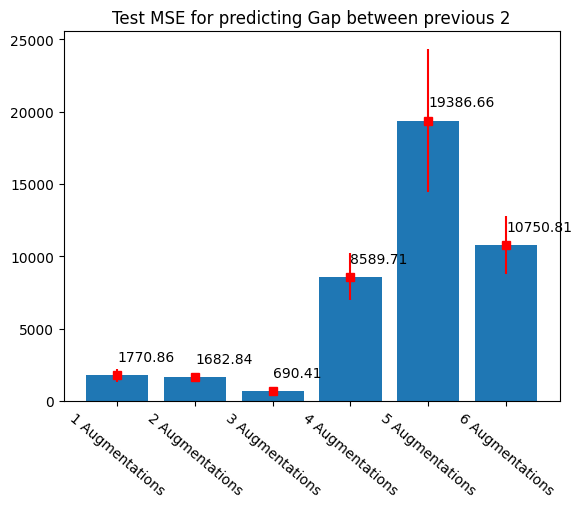

Saving to imgs/aug_sweepBiggerImgs/Electronic spatial extent_n_augs_multitrial.png


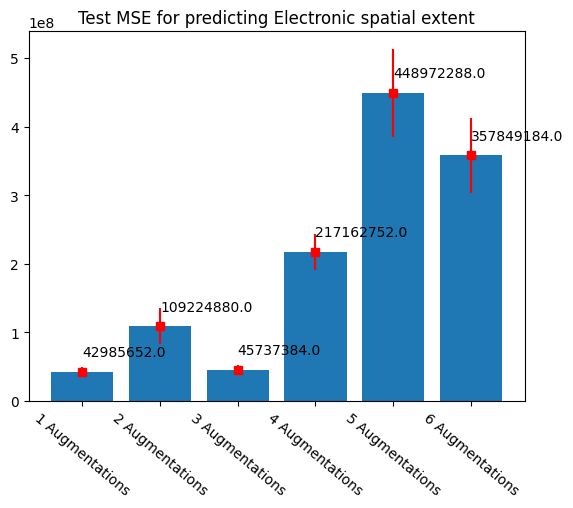

Saving to imgs/aug_sweepBiggerImgs/Zero point vibrational energy_n_augs_multitrial.png


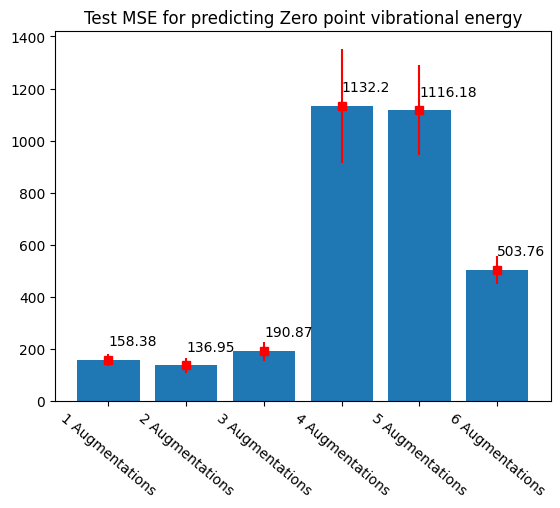

Saving to imgs/aug_sweepBiggerImgs/Internal energy at 0K_n_augs_multitrial.png


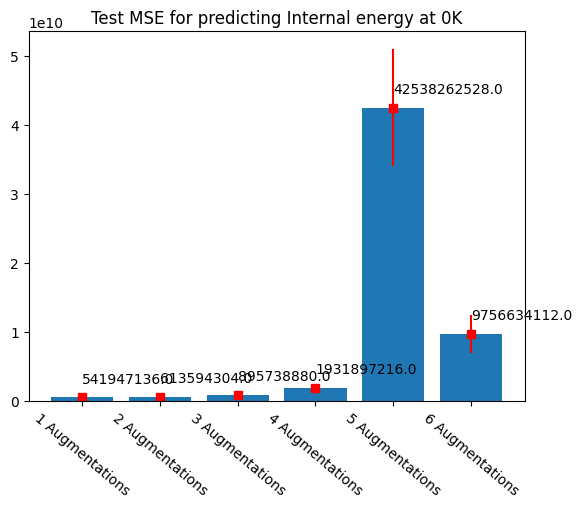

Saving to imgs/aug_sweepBiggerImgs/Internal energy at 298.15K_n_augs_multitrial.png


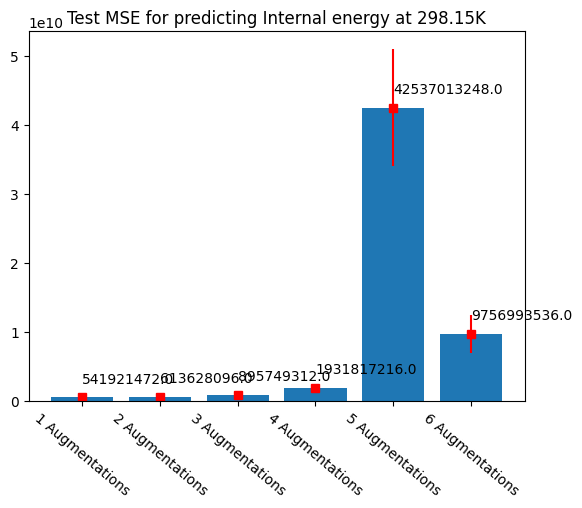

Saving to imgs/aug_sweepBiggerImgs/Enthalpy at 298.15K_n_augs_multitrial.png


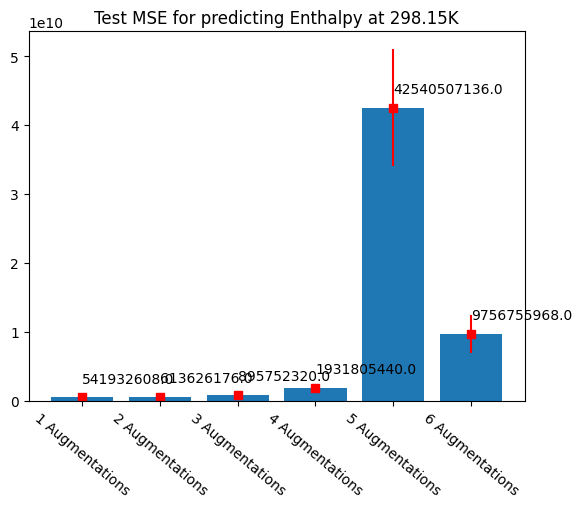

Saving to imgs/aug_sweepBiggerImgs/Free energy at 298.15K_n_augs_multitrial.png


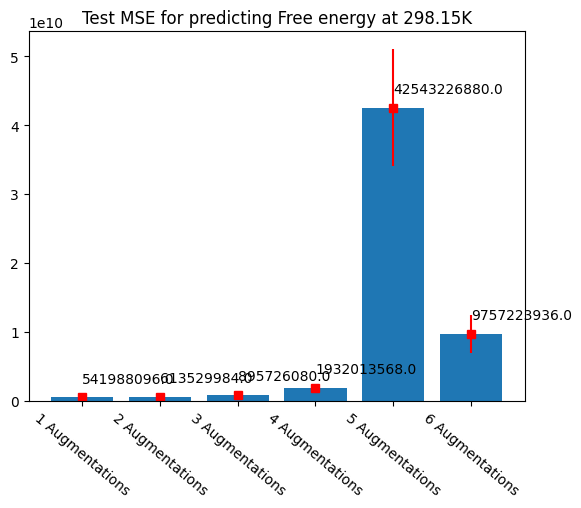

Saving to imgs/aug_sweepBiggerImgs/Heat capavity at 298.15K_n_augs_multitrial.png


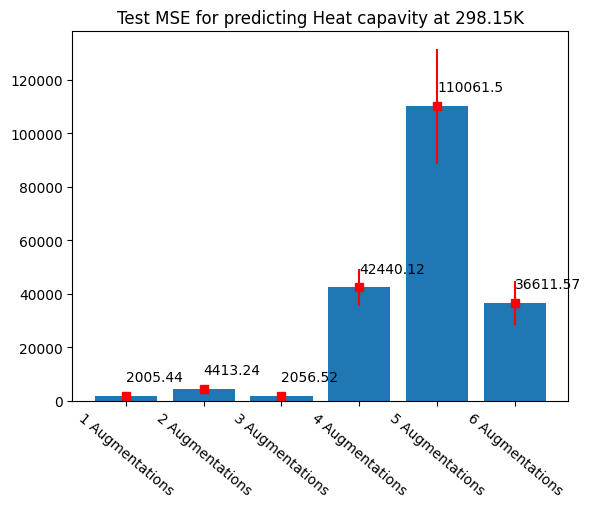

Saving to imgs/aug_sweepBiggerImgs/Atomization energy at 0K_n_augs_multitrial.png


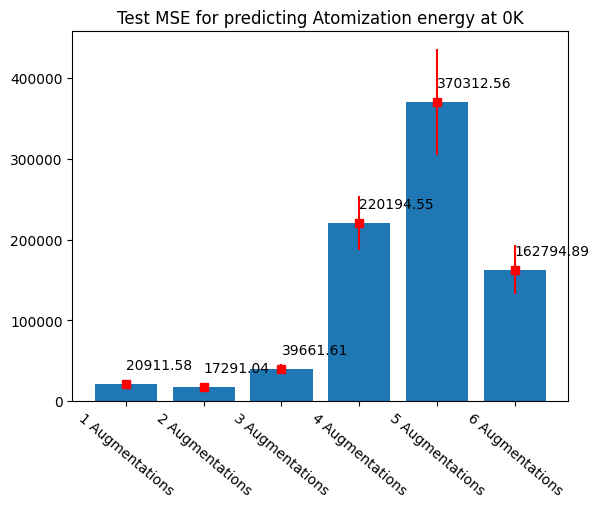

Saving to imgs/aug_sweepBiggerImgs/Atomization energy at 298.15K_n_augs_multitrial.png


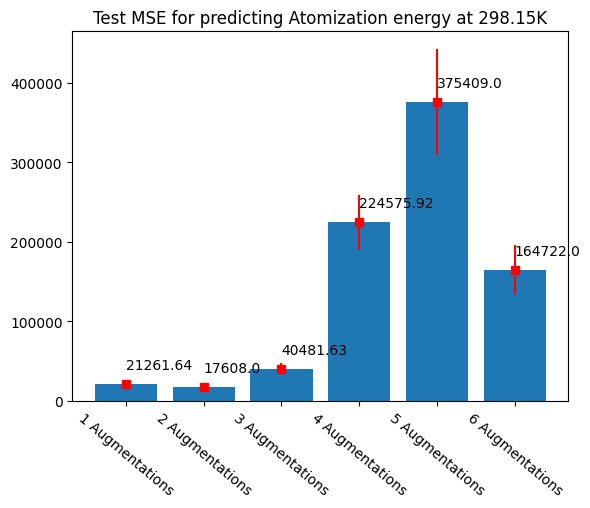

Saving to imgs/aug_sweepBiggerImgs/Atomization enthalpy at 298.15K_n_augs_multitrial.png


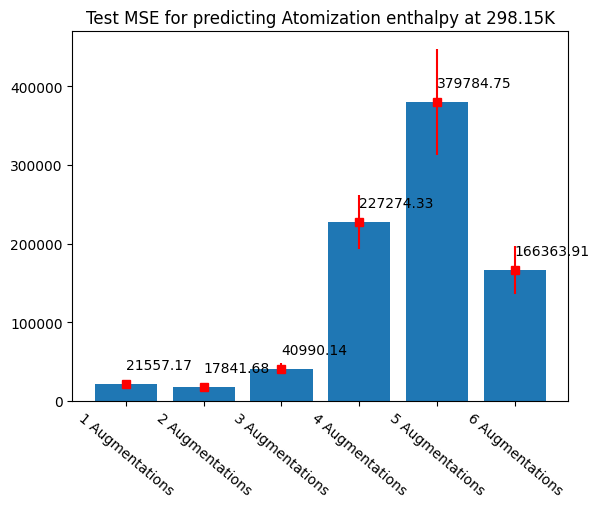

Saving to imgs/aug_sweepBiggerImgs/Atomization free energy at 298.15K_n_augs_multitrial.png


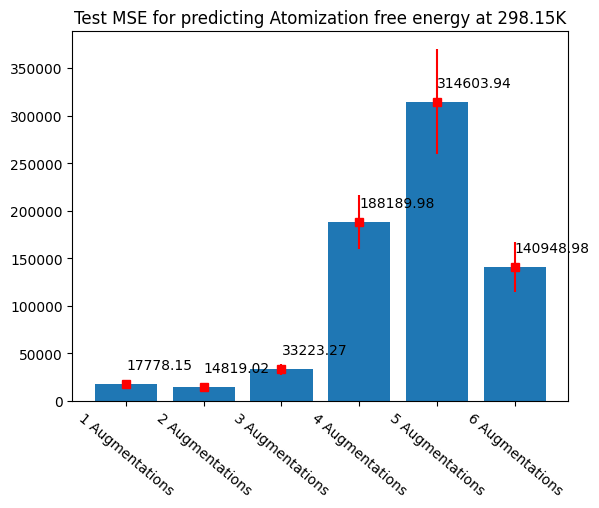

Saving to imgs/aug_sweepBiggerImgs/Rotational constant A_n_augs_multitrial.png


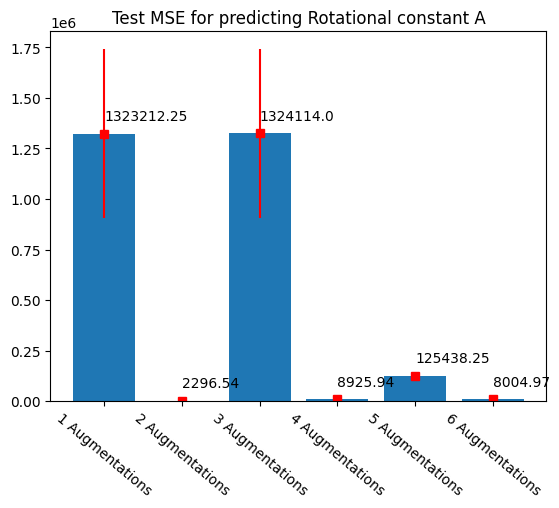

Saving to imgs/aug_sweepBiggerImgs/Rotational constant B_n_augs_multitrial.png


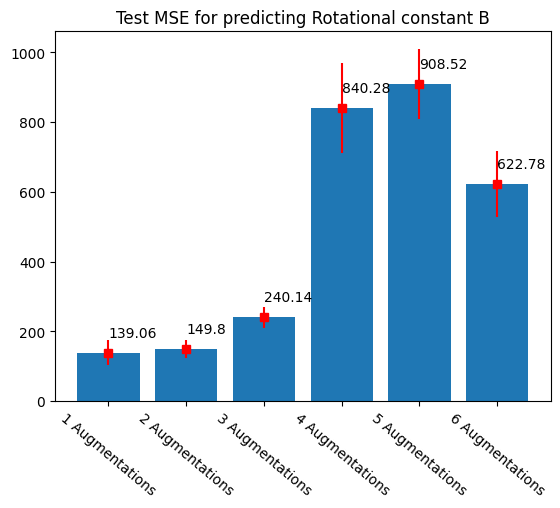

Saving to imgs/aug_sweepBiggerImgs/Rotational constant C_n_augs_multitrial.png


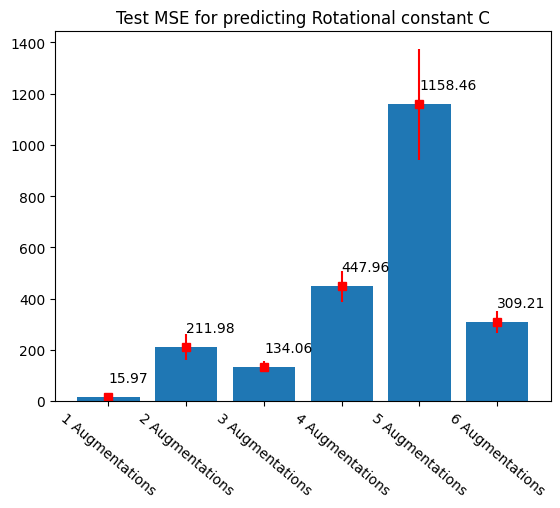

NameError: name 'breaker' is not defined

In [19]:
# Subset selection techniques for set of n augmentations:

# 'best' would be running all 2^n permutations

# 'forward' would mean doing n^2: first n, consdier second n, ..., n times
# 'backward' same number

# Iterate over the data files to load them, build a score tensor

# For each downstream, show a bar plot of the relative performances of 1,2,3,4 augmentations

mat = torch.zeros((max_augs, n_trials, 19))

for aug_n in range(1, max_augs+1):
    
    for trial in range(n_trials):

        tr_losses = torch.load(f'aug_sweepBigger/tr_{aug_n}_{trial}.pt') # save the training scores
        val_losses = torch.load(f'aug_sweepBigger/val_{aug_n}_{trial}.pt') # save the validation scores
        augmentation_list = torch.load(f'aug_sweepBigger/aug_{aug_n}_{trial}.pt') # save the augmentation
        scores = torch.load(f'aug_sweepBigger/scores_{aug_n}_{trial}.pt') # save the scores
        #print(len(scores))
        
        for i, score in enumerate(scores):
            mat[aug_n-1, trial, i] = score
            
mat = mat.permute(2,0,1) # to: task, n_aug, trials

for i, row in enumerate(mat):
    #print(row.shape)
    means = torch.mean(row, dim = 1)
    sders = torch.std(row, dim = 1) / n_trials
    
    #print(means.shape, sds.shape)
    x = range(means.shape[0])
    
    # Bars
    plt.bar(x, means)
    
    # Errorbars
    plt.errorbar(x, means, yerr = sders, fmt = 's', color = 'red')
    
    # Annotate
    for j, val in enumerate(means):
        plt.annotate(round(val.item(), 2), (j, val + 0.05*max(means)))
    
    plt.xticks(x, [str(x+1)+' Augmentations' for x in range(means.shape[0])], rotation = -40)
    plt.title(f'Test MSE for predicting {qm9_index[i]}')
    
    #plt.ylim(0,torch.mean(means))
    
    print('Saving to', f'imgs/aug_sweepBiggerImgs/{qm9_index[i]}_n_augs_multitrial.png')
    plt.savefig(f'imgs/aug_sweepBiggerImgs/{qm9_index[i]}_n_augs_multitrial.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/aug_sweepBiggerImgs/{qm9_index[i]}_n_augs_multitrial.pdf', bbox_inches = 'tight')
    plt.show()

print(breaker)

In [20]:
# Load the resuls and say if including an augmentation is good or not


# Iterate over augmentations:
for aug in augs:
    print('may need to split this nasty string thing to get the augmentation name back out', aug)
    
    belongs = []
    didnts = []
    # iterate over the saved scores:
    for aug_n in range(1, max_augs + 1):
        
        for trial in range(n_trials):
            # Get the scores for this iteration:
            scores = torch.load(f'aug_sweep1234/scores_{aug_n}_{trial}.pt')
            print('scores tensor', scores.shape)
            augmentation_list = torch.load(f'aug_sweep1234/aug_{aug_n}_{trial}.pt')

            # Did the current augmentation belong: if so append to belongs
            if aug in augmentation_list:
                belongs.append(scores)

            # if not append to didnts
            else:
                didnts.append(scores)
            
    belongs = torch.stack(belongs, dim = 0)
    didnts = torch.stack(didnts, dim = 0)
    print('For augmentation', aug, 'got scores', belongs.shape, didnts.shape)

IndentationError: expected an indented block after 'for' statement on line 13 (3894667903.py, line 15)

In [ ]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations
import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling

aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

print(aug, type(aug))

# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==1]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'aug_sweep1/{tr_strs[0]}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'aug_sweep1/{tr_strs[0]}/model.pt')
    torch.save(train_loss,  f'aug_sweep1/{tr_strs[0]}/train_loss.pt')
    torch.save(val_loss,  f'aug_sweep1/{tr_strs[0]}/val_loss.pt')
    torch.save(transfer_mat,  f'aug_sweep1/{tr_strs[0]}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

In [ ]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations


# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==3]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002

experiment = 'aug_sweep3-4'
trymkdir(experiment)
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'{experiment}/{tr_strs}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'{experiment}/{tr_strs}/model.pt')
    torch.save(train_loss,  f'{experiment}/{tr_strs}/train_loss.pt')
    torch.save(val_loss,  f'{experiment}/{tr_strs}/val_loss.pt')
    torch.save(transfer_mat,  f'{experiment}/{tr_strs}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

In [ ]:
mse_scores = torch.zeros((19, len(aug_strs)))
for i_str, stri in enumerate(aug_strs):
    vec = torch.load(f'aug_sweep1/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep1/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

In [ ]:
#print(mse_scores, mse_scores.shape)

# For one score, 

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), aug_strs)
    plt.xlabel('Single Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    plt.show()

In [ ]:
# For all-but-one-augmentation
mse_scores = torch.zeros((19, len(aug_strs)))

#augs = os.walk('aug_sweep3-4')
print(next(os.walk('aug_sweep3-4'))[1])

for i_str, stri in enumerate(next(os.walk('aug_sweep3-4'))[1]):
    vec = torch.load(f'aug_sweep3-4/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep3-4/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

#print(mse_scores, mse_scores.shape)

# For one score, 



In [ ]:
# I would also add a column for "naive estimator"
# This could be a simple regressor, or a mean estimator (like Eric)

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), ['NOT '+x for x in aug_strs], rotation = -30)
    plt.xlabel('Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
    plt.show()
    

In [ ]:
# Further step would be summarizing the average ranks of the models to summarize 19 QM's into 1 rank
import scipy.stats as ss
# For each QM9_index, find the min of the row -> this index is the best augmentation
print('PLEASE NOTE THESE ARE RANKS INTEGERS NOT INDEXES:')

ranks = []
for i, row in enumerate(mse_scores):
    elem = torch.argmin(row).item()
    
    # For each element of the qm9 row, 
    rank = ss.rankdata(row)
    
    ranks.append(torch.FloatTensor(rank))
    
ranks = torch.stack(ranks)
print(ranks.shape)
meanranks= torch.mean(ranks, dim = 0)
print(meanranks)

plt.bar(range(4), meanranks)
plt.xticks(range(4), ['NOT '+x for x in aug_strs], rotation = -30)
plt.ylabel('Average Rank')
plt.xlabel('Augmentation')
plt.title('Average Augmentation Rank Across Transfer Tasks')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
plt.show()